In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [4]:
img_size = 48

In [5]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)



train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [6]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [7]:
len(train_generator)

359

In [8]:
X_train.shape

(64, 48, 48, 1)

In [9]:
y_train.shape

(64, 7)

In [10]:
X_test.shape

(64, 48, 48, 1)

In [11]:
y_test.shape

(64, 7)

In [12]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


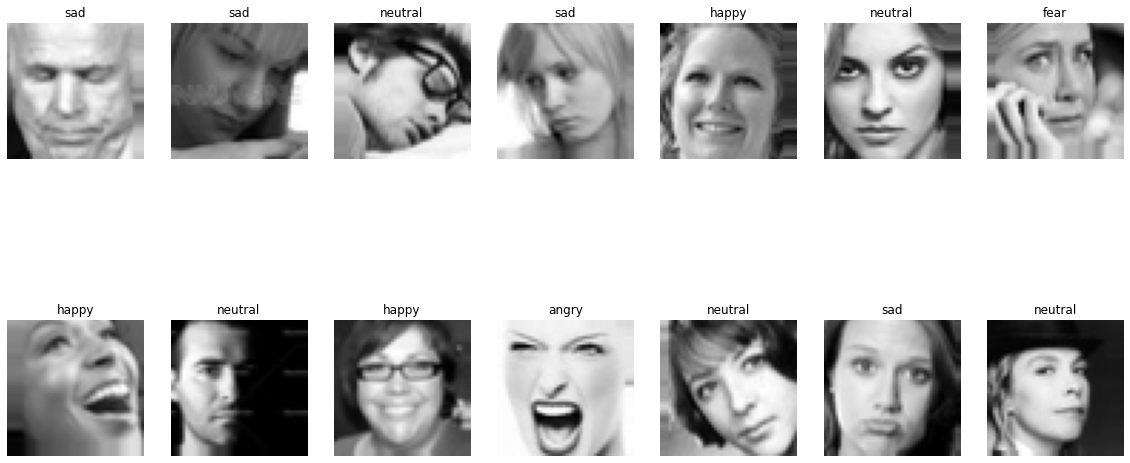

In [13]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [14]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [15]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [16]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [17]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [18]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [19]:
def model_five(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = convolutional_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = convolutional_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = convolutional_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "model_two")
    return model

In [20]:
model = model_five(shape = (48, 48, 1), classes = 7)

epochs = 200
batch_size = 64
model.summary()

Model: "model_two"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                               

                                                                                                  
 activation_8 (Activation)      (None, 7, 7, 128)    0           ['add_3[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 7, 7, 128)    0           ['activation_8[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 128)    147584      ['dropout[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 7, 7, 128)   512         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_18 (BatchN  (None, 7, 7, 128)   512         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 7, 7, 128)    0           ['batch_normalization_18[0][0]', 
                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 7, 7, 128)    0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_20 (Conv2D)             (None, 4, 4, 256)    295168      ['activation_18[0][0]']          
          

 conv2d_29 (Conv2D)             (None, 4, 4, 256)    590080      ['dropout_3[0][0]']              
                                                                                                  
 batch_normalization_27 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_30[0][0]']              
 ormalizat

                                                                  'activation_34[0][0]']          
                                                                                                  
 activation_36 (Activation)     (None, 4, 4, 256)    0           ['add_17[0][0]']                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_36[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_37[0][0]'] 
          

 activation_45 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_45[0][0]']          
                                                                                                  
 batch_normalization_46 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_22 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_46[0][0]', 
                                                                  'dropout_6[0][0]']              
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_55 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_56 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
          

In [21]:
learning_rate = 0.001
decay_rate = learning_rate / 25
# momentum = 0.8
opt = Adam(lr=learning_rate,  decay=decay_rate)


model.compile(
    optimizer = opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    'fer-441.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [23]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = epochs,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights,callbacks=[checkpoint])

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 2.4845 - accuracy: 0.1325
Epoch 1: val_accuracy improved from -inf to 0.13268, saving model to fer-441.h5
359/359 [==============================] - 283s 742ms/step - loss: 2.4845 - accuracy: 0.1325 - val_loss: 2.0220 - val_accuracy: 0.1327
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 1.9407 - accuracy: 0.1567
Epoch 2: val_accuracy improved from 0.13268 to 0.18785, saving model to fer-441.h5
359/359 [==============================] - 119s 331ms/step - loss: 1.9407 - accuracy: 0.1567 - val_loss: 1.8915 - val_accuracy: 0.1878
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 1.9221 - accuracy: 0.1852
Epoch 3: val_accuracy did not improve from 0.18785
359/359 [==============================] - 113s 313ms/step - loss: 1.9221 - accuracy: 0.1852 - val_loss: 1.9323 - val_accuracy: 0.1788
Epoch 4/200
359/359 [==============================] - ETA: 0s - loss: 1.9059 - accuracy: 

Epoch 29/200
359/359 [==============================] - ETA: 0s - loss: 1.3388 - accuracy: 0.4599
Epoch 29: val_accuracy did not improve from 0.46648
359/359 [==============================] - 123s 341ms/step - loss: 1.3388 - accuracy: 0.4599 - val_loss: 1.4191 - val_accuracy: 0.4532
Epoch 30/200
359/359 [==============================] - ETA: 0s - loss: 1.3145 - accuracy: 0.4719
Epoch 30: val_accuracy improved from 0.46648 to 0.51676, saving model to fer-441.h5
359/359 [==============================] - 130s 361ms/step - loss: 1.3145 - accuracy: 0.4719 - val_loss: 1.2822 - val_accuracy: 0.5168
Epoch 31/200
359/359 [==============================] - ETA: 0s - loss: 1.3021 - accuracy: 0.4803
Epoch 31: val_accuracy did not improve from 0.51676
359/359 [==============================] - 123s 342ms/step - loss: 1.3021 - accuracy: 0.4803 - val_loss: 1.3993 - val_accuracy: 0.4567
Epoch 32/200
359/359 [==============================] - ETA: 0s - loss: 1.2999 - accuracy: 0.4710
Epoch 32: val_a

359/359 [==============================] - ETA: 0s - loss: 0.8663 - accuracy: 0.6388
Epoch 85: val_accuracy did not improve from 0.62081
359/359 [==============================] - 124s 344ms/step - loss: 0.8663 - accuracy: 0.6388 - val_loss: 1.1986 - val_accuracy: 0.5782
Epoch 86/200
359/359 [==============================] - ETA: 0s - loss: 0.8543 - accuracy: 0.6467
Epoch 86: val_accuracy did not improve from 0.62081
359/359 [==============================] - 124s 345ms/step - loss: 0.8543 - accuracy: 0.6467 - val_loss: 1.1695 - val_accuracy: 0.5670
Epoch 87/200
359/359 [==============================] - ETA: 0s - loss: 0.8631 - accuracy: 0.6432
Epoch 87: val_accuracy did not improve from 0.62081
359/359 [==============================] - 124s 345ms/step - loss: 0.8631 - accuracy: 0.6432 - val_loss: 1.2268 - val_accuracy: 0.5475
Epoch 88/200
359/359 [==============================] - ETA: 0s - loss: 0.8653 - accuracy: 0.6395
Epoch 88: val_accuracy did not improve from 0.62081
359/359 

359/359 [==============================] - 122s 339ms/step - loss: 0.7510 - accuracy: 0.6909 - val_loss: 1.1036 - val_accuracy: 0.6061
Epoch 114/200
359/359 [==============================] - ETA: 0s - loss: 0.7474 - accuracy: 0.6870
Epoch 114: val_accuracy did not improve from 0.63687
359/359 [==============================] - 121s 338ms/step - loss: 0.7474 - accuracy: 0.6870 - val_loss: 1.1163 - val_accuracy: 0.6082
Epoch 115/200
359/359 [==============================] - ETA: 0s - loss: 0.7297 - accuracy: 0.6916
Epoch 115: val_accuracy did not improve from 0.63687
359/359 [==============================] - 121s 337ms/step - loss: 0.7297 - accuracy: 0.6916 - val_loss: 1.0876 - val_accuracy: 0.6075
Epoch 116/200
359/359 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.7028
Epoch 116: val_accuracy did not improve from 0.63687
359/359 [==============================] - 121s 338ms/step - loss: 0.7110 - accuracy: 0.7028 - val_loss: 1.1531 - val_accuracy: 0.5740
Epoc

Epoch 142/200
359/359 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.7467
Epoch 142: val_accuracy did not improve from 0.64316
359/359 [==============================] - 123s 343ms/step - loss: 0.6105 - accuracy: 0.7467 - val_loss: 1.0921 - val_accuracy: 0.6250
Epoch 143/200
359/359 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.7401
Epoch 143: val_accuracy did not improve from 0.64316
359/359 [==============================] - 123s 343ms/step - loss: 0.6229 - accuracy: 0.7401 - val_loss: 1.0472 - val_accuracy: 0.6355
Epoch 144/200
359/359 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.7435
Epoch 144: val_accuracy did not improve from 0.64316
359/359 [==============================] - 123s 343ms/step - loss: 0.6186 - accuracy: 0.7435 - val_loss: 1.0966 - val_accuracy: 0.6173
Epoch 145/200
359/359 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.7446
Epoch 145: val_accuracy did not improve 

359/359 [==============================] - 125s 348ms/step - loss: 0.5346 - accuracy: 0.7806 - val_loss: 1.1095 - val_accuracy: 0.6194
Epoch 171/200
359/359 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.7751
Epoch 171: val_accuracy did not improve from 0.64735
359/359 [==============================] - 124s 347ms/step - loss: 0.5453 - accuracy: 0.7751 - val_loss: 1.0843 - val_accuracy: 0.6187
Epoch 172/200
359/359 [==============================] - ETA: 0s - loss: 0.5541 - accuracy: 0.7731
Epoch 172: val_accuracy did not improve from 0.64735
359/359 [==============================] - 125s 348ms/step - loss: 0.5541 - accuracy: 0.7731 - val_loss: 1.1018 - val_accuracy: 0.6229
Epoch 173/200
359/359 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.7820
Epoch 173: val_accuracy did not improve from 0.64735
359/359 [==============================] - 125s 347ms/step - loss: 0.5337 - accuracy: 0.7820 - val_loss: 1.1109 - val_accuracy: 0.6229
Epoc

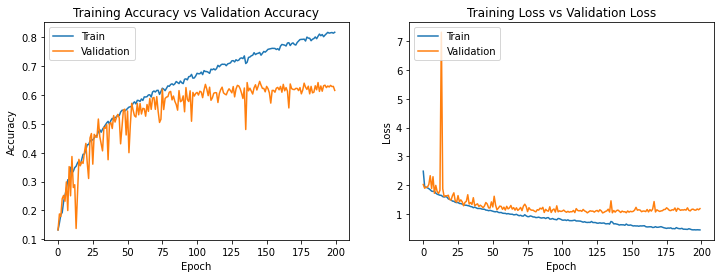

In [24]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [25]:
model.save('deeperdropout441_200_model.h5')
model.save_weights('deeperdropout441_200_weights.h5')

In [26]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 2s 86ms/step - loss: 1.1818 - accuracy: 0.6159
final train accuracy = 82.93 , validation accuracy = 61.59


23/23 [==============================] - 4s 83ms/step
Confusion Matrix
[[41  4 20 50 20 41 15]
 [ 1  0  3  6  4  5  3]
 [26  2 43 51 25 37 20]
 [49  3 67 74 58 77 26]
 [39  5 43 47 41 49 22]
 [23  3 41 51 42 55 34]
 [25  4 27 40 20 32 18]]
Classification Report
              precision    recall  f1-score   support

       angry       0.20      0.21      0.21       191
     disgust       0.00      0.00      0.00        22
        fear       0.18      0.21      0.19       204
       happy       0.23      0.21      0.22       354
     neutral       0.20      0.17      0.18       246
         sad       0.19      0.22      0.20       249
    surprise       0.13      0.11      0.12       166

    accuracy                           0.19      1432
   macro avg       0.16      0.16      0.16      1432
weighted avg       0.19      0.19      0.19      1432



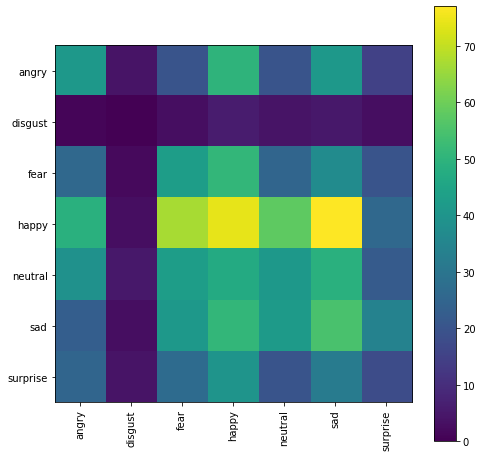

In [27]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 31s 86ms/step
Confusion Matrix
[[ 451   54  451  733  516  648  343]
 [  59    9   49   85   63   51   33]
 [ 460   59  532  768  532  592  335]
 [ 760   80  892 1380  928 1158  574]
 [ 542   64  602  914  680  766  404]
 [ 551   57  617  891  619  747  382]
 [ 371   42  352  611  392  536  233]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3196
     disgust       0.02      0.03      0.03       349
        fear       0.15      0.16      0.16      3278
       happy       0.26      0.24      0.25      5772
     neutral       0.18      0.17      0.18      3972
         sad       0.17      0.19      0.18      3864
    surprise       0.10      0.09      0.10      2537

    accuracy                           0.18     22968
   macro avg       0.15      0.15      0.15     22968
weighted avg       0.18      0.18      0.18     22968



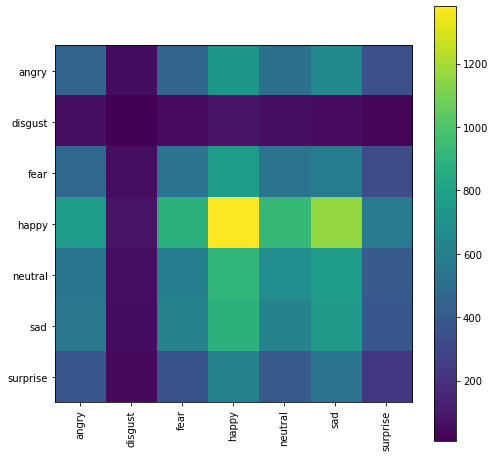

In [28]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [2]:
model = tf.keras.models.load_model('fer-441.h5')

In [7]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 4s 164ms/step - loss: 1.0742 - accuracy: 0.6473
final train accuracy = 75.61 , validation accuracy = 64.73


23/23 [==============================] - 3s 88ms/step
Confusion Matrix
[[25  1 19 43 35 41 27]
 [ 0  1  1  5  3  6  6]
 [20  1 30 39 44 43 27]
 [57  5 35 74 61 86 36]
 [36  4 26 52 49 51 28]
 [41  5 32 58 43 46 24]
 [24  2 20 39 23 42 16]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.13      0.13       191
     disgust       0.05      0.05      0.05        22
        fear       0.18      0.15      0.16       204
       happy       0.24      0.21      0.22       354
     neutral       0.19      0.20      0.19       246
         sad       0.15      0.18      0.16       249
    surprise       0.10      0.10      0.10       166

    accuracy                           0.17      1432
   macro avg       0.15      0.14      0.15      1432
weighted avg       0.17      0.17      0.17      1432



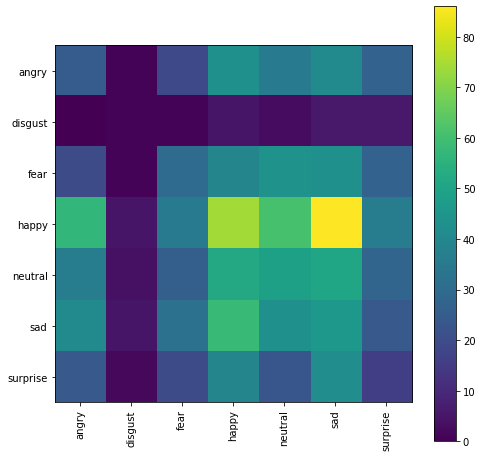

In [8]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 28s 77ms/step
Confusion Matrix
[[ 390   47  387  735  513  770  354]
 [  44    9   54   82   61   63   36]
 [ 397   57  386  774  511  775  378]
 [ 663  100  688 1390  985 1277  669]
 [ 471   57  467  933  708  891  445]
 [ 437   57  451  856  707  932  424]
 [ 301   29  304  594  443  584  282]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.12      0.13      3196
     disgust       0.03      0.03      0.03       349
        fear       0.14      0.12      0.13      3278
       happy       0.26      0.24      0.25      5772
     neutral       0.18      0.18      0.18      3972
         sad       0.18      0.24      0.20      3864
    surprise       0.11      0.11      0.11      2537

    accuracy                           0.18     22968
   macro avg       0.15      0.15      0.15     22968
weighted avg       0.18      0.18      0.18     22968



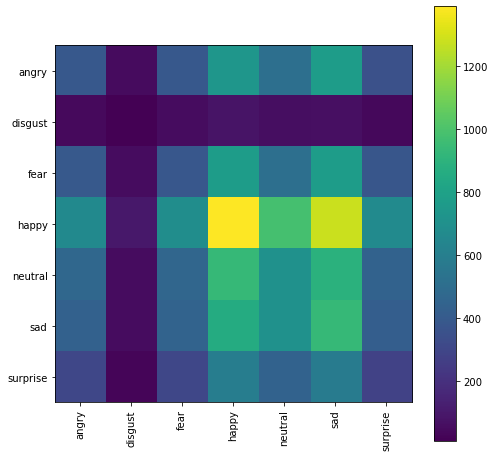

In [9]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [52]:
train_generator.reset()
X_train, y_train = next(train_generator)
for i in range(int(len(train_generator))-1): #1st batch is already fetched before the for loop.
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

(22968, 48, 48, 1) (22968, 7)


In [53]:
ypred = model.predict(X_train)
ypred = ypred.argmax(axis=-1)
ypred


ytrain = y_train.argmax(axis=-1)
ytrain


718/718 [==============================] - 44s 59ms/step


array([2, 6, 3, ..., 5, 6, 0], dtype=int64)

NameError: name 'ytrain' is not defined

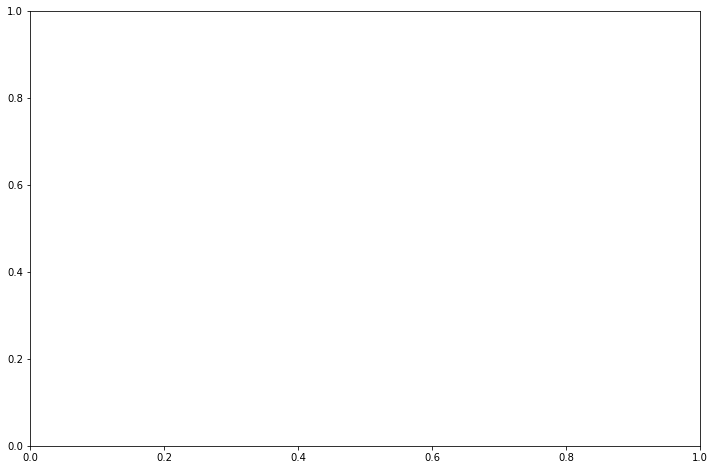

In [2]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['angry', 'disgust', 'fear', 'happy', 'neutral',
          'sad', 'surprise']
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [57]:
validation_generator.reset()
X_test, y_test = next(validation_generator)
for i in range(int(len(validation_generator))-1): #1st batch is already fetched before the for loop.
    img, label = next(validation_generator)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

(1432, 48, 48, 1) (1432, 7)


In [58]:
ypred_test = model.predict(X_test)
ypred_test = ypred_test.argmax(axis=-1)



ytest = y_test.argmax(axis=-1)


45/45 [==============================] - 3s 63ms/step


ROC AUC score: 0.7912001425029264


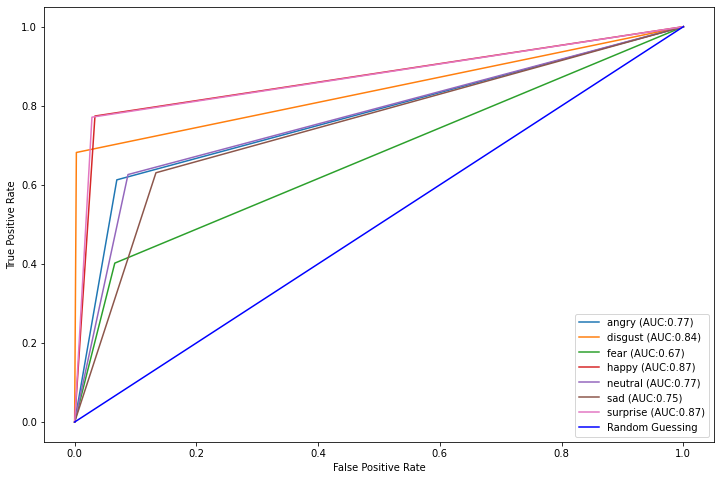

In [59]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytest, ypred_test))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()